In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

BATCH_SIZE = 32
IMG_SIZE = (150, 150)
EPOCHS = 30
SEED = 123


In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

if os.path.exists(os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')):
    PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
else:
    PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_extracted', 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

print("Train dir:", train_dir)
print("Validation dir:", validation_dir)
assert os.path.exists(train_dir), "Train folder not found!"
assert os.path.exists(validation_dir), "Validation folder not found!"


Train dir: C:\Users\DELL\.keras\datasets\cats_and_dogs_extracted\cats_and_dogs_filtered\train
Validation dir: C:\Users\DELL\.keras\datasets\cats_and_dogs_extracted\cats_and_dogs_filtered\validation


In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Classes: ['cats', 'dogs']


In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")


In [20]:
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = layers.Rescaling(1./255)

def preprocess(ds):
    return ds.map(lambda x, y: (normalization_layer(x), y),
                  num_parallel_calls=AUTOTUNE)

train_ds = preprocess(train_ds).cache().shuffle(1000, seed=SEED).prefetch(buffer_size=AUTOTUNE)
val_ds   = preprocess(val_ds).cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)


In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 659ms/step - accuracy: 0.5215 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6877
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 787ms/step - accuracy: 0.5465 - loss: 0.6864 - val_accuracy: 0.5720 - val_loss: 0.6794
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 943ms/step - accuracy: 0.5860 - loss: 0.6731 - val_accuracy: 0.5580 - val_loss: 0.6721
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6130 - loss: 0.6621 - val_accuracy: 0.5840 - val_loss: 0.6665
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 607ms/step - accuracy: 0.6250 - loss: 0.6536 - val_accuracy: 0.6380 - val_loss: 0.6358
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6380 - loss: 0.6413 - val_accuracy: 0.6320 - val_loss: 0.6376
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 595ms/step - accuracy: 0.6515 - loss: 0.6360 - val_accuracy: 0.6320 - val_loss: 0.6301
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 922ms/step - accuracy: 0.6595 - loss: 0.6248 - val_accuracy: 

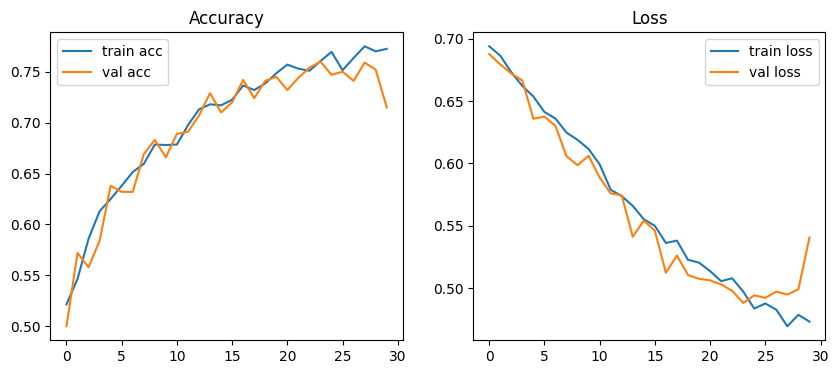

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


In [25]:
eval_res = model.evaluate(val_ds, verbose=0)
print(f"Validation — loss: {eval_res[0]:.4f} | acc: {eval_res[1]:.4f}")


Validation — loss: 0.5406 | acc: 0.7150
